# __Training and tuning the neural network__
- Dataset: Guarujá Municipality - São Paulo - Brazil
- Part 2/3

## Authorship:
        Caio Azevedo
        São Paulo University, February, 2024

## Main goals:

- Data processing for neural network application:
   - Elimination of extraneous features.
   - Normalization of the dataset.
   - ANN training, testing and validation dataset split.

- Training and evaluation of neural networks:
   - Custom neural network implementation.
   - Keras neural network implementation.
   
- Automation of hyperparameter setup for improved performance (criterion: accuracy).
   - Brute force for optimizing hyperparameters in the custom network.
   - Keras Tuning for optimizing Keras hyperparameters.
   
- Neural network performance assessment with and without 'less important features'.

- Compare custom ANN with Keras framework

## Coding

### Imported libraries

In [1]:
import datetime
start = datetime.datetime.now()

In [2]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from utils import plot

%matplotlib inline

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

### Auxiliary functions

In [6]:
# Compute and display performance metrics 
def NetworkPerformance(y_real, y_prob):
    y_predict = (y_prob > 0.5)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_real, y_predict)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_real, y_predict)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_real, y_predict)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_real, y_predict)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_real, y_predict)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_real, y_prob)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_real, y_predict)
    print(matrix)

In [7]:
# Compute and print ROC curve
def printAUROC(y_real,y_predict):
    ns_auc = roc_auc_score(y_real, y_predict)
    # summarize scores
    print('AUC ROC=%.4f' % (ns_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_real, y_predict)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    # plot the roc curve for the model
    plt.plot(p_fpr, p_tpr, linestyle='--', label='random', color='orange')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ANN', color='blue')
    
    # axis labels
    pyplot.xlabel('false positive rate')
    pyplot.ylabel('true positive rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [8]:
# split data into training, validation and testing sets
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

In [9]:
# Plot a bubble chart with two features according to NN classification
def bubble_chart(data, col_2_buble_size, col_x, col_y):
    fig, ax = plt.subplots(figsize=(15,13))
    sizes = data[col_2_buble_size]*10
    scatter = ax.scatter(data[col_x], data[col_y], 
           c=(dataset['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    ax.title.set_text("{}{}".format(len(data.index), ' landslides samples')) 

    plt.show()

In [10]:
# Plot a bubble chart with two features according to NN classification and the actual values

def  bubble_double_chart(data, col_2_buble_size, col_x, col_y):
    sizes = data[col_2_buble_size]*10

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

    scatter = axes[0].scatter(data[col_x], data['elevation'],
            c=(data['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    scatter = axes[1].scatter(data[col_x], data[col_y],
            c=(data['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    fig.tight_layout()
    text = 'predicted landslides ' + 'accuracy : {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
    axes[0].title.set_text('actual landslides')
    axes[1].title.set_text(text)

    plt.show()

### Select the dataset

- Switch one among the nine samples used in this study. The samples are configured according to the landslides' non-occurrence points' distance from the respective occurrence spot.

In [11]:
APP_PATH = os.getcwd()
#file = "Input_Guaruja_50m_shuffled.csv"
#file = "Input_Guaruja_100m_shuffled.csv"
#file = "Input_Guaruja_150m_shuffled.csv"
file = "Input_Guaruja_200m_shuffled.csv"

#file = "pt_non-occurrence_1km_shuffled.csv"
#file = "pt_non-occurrence_2km_shuffled.csv"
#file = "pt_non-occurrence_3km_shuffled.csv"
#file = "pt_non-occurrence_4km_shuffled.csv"

#file = "guaruja_random.csv"

dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 

# load the dataset
dataset_original = dataset.copy()
dataset.head(5)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
0,174,380188.0000,7355077.000,4.319798,-0.015372,33.860043,25.912239,277.485138,65,90,1
1,1,369756.0000,7344220.000,16.590740,-0.043386,0.727488,0.418544,159.017288,2,90,0
2,62,376611.0000,7353497.000,16.493561,-0.011949,1.114157,1.117189,142.506317,2,90,0
3,110,372569.0000,7346250.000,5.782696,-0.010980,20.309313,9.144706,306.605927,2,30,1
4,109,370946.0334,7346022.025,4.132583,-0.000184,43.904831,46.628563,316.640686,2,30,1


In [12]:
dataset.shape

(197, 11)

In [13]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
count,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.00,197.0
mean,99.00,375519.78,7350881.70,5.82,0.12,19.82,47.63,200.24,33.34,69.64,0.5
std,57.01,3796.70,4126.95,3.01,2.04,12.34,54.07,105.75,31.58,29.94,0.5
min,1.00,366577.00,7344020.00,1.37,-18.47,0.03,0.00,0.30,2.00,20.00,0.0
25%,50.00,372439.00,7347513.00,4.03,-0.02,11.59,7.82,108.77,2.00,30.00,0.0
50%,99.00,375221.00,7348949.00,4.96,-0.00,20.69,25.91,202.57,2.00,90.00,1.0
75%,148.00,379188.00,7354877.00,6.41,0.02,27.52,69.85,302.54,65.00,90.00,1.0
max,197.00,381355.00,7357501.00,16.59,11.10,68.52,230.08,359.51,65.00,120.00,1.0


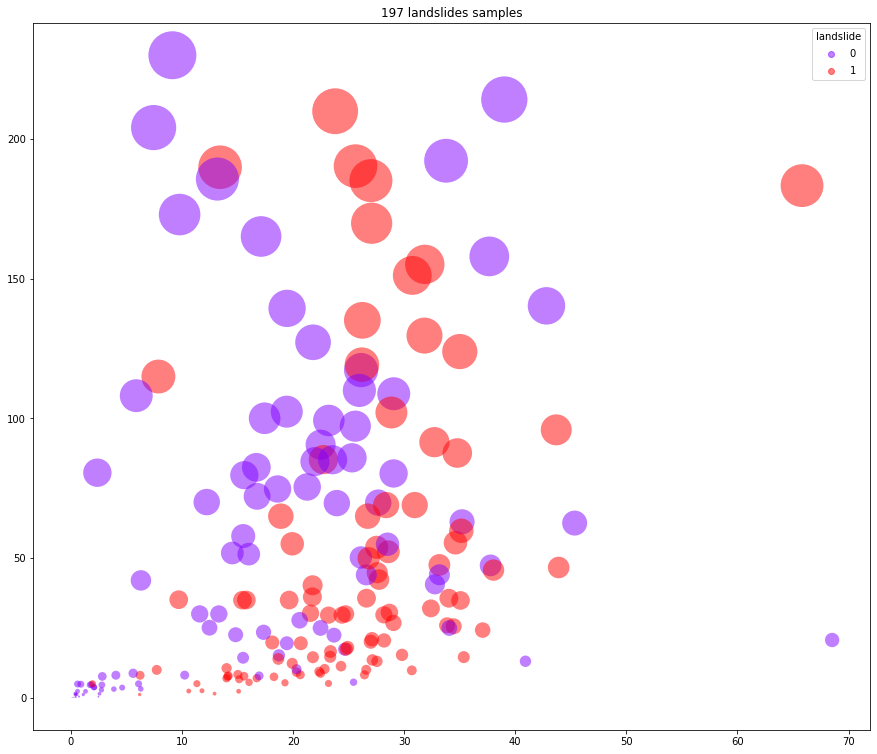

In [14]:
bubble_chart(dataset,"elevation","slope","elevation")

### Data Preparation
 - Based on the results of the feature importance analysis, all features were retained for training the ANN.
 - We addressed concerns about data leakage.

 - About most important features in best performed samples

  - Considering the random and 200m samples those with the best performance.
  - According to previous analyses we notice some features are less relevant than others.

     - In the scenario of a random sample, the pivotal features are identified as **twi**, **elevation**, and **land_use**. The overall accuracy, achieved with the optimal configuration using only these features, stands at approximately 98.50%, while utilizing all features yields a consistent 99% accuracy.

     - In instances where an event does not occur within a 200-meter radius of the sample occurrence, the most crucial features include **slope**, **twi**, **aspect**, and **curvature**. The overall accuracy, achieved with the best configuration using these features, is approximately 94.92%, compared to 93.91% when utilizing all features, a result that remains consistent.

After conducting numerous tests, it has been observed that the accuracy of the Artificial Neural Network (ANN) remains largely consistent, whether the most crucial features are included or not. Consequently, the decision has been made to retain all features in the model.

In [15]:
dataset = dataset[['slope','aspect','elevation','land_use','lithology','twi','curvature','class']]

#dataset = dataset.drop('slope',axis=1)
#dataset = dataset.drop('aspect',axis=1)

#dataset = dataset.drop('lithology',axis=1)
#dataset = dataset.drop('curvature',axis=1)

#dataset = dataset.drop('elevation',axis=1)
#dataset = dataset.drop('land_use',axis=1)

#dataset.head(5)

In [16]:
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation(dataset)

In [17]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

95 train examples
42 validation examples
60 test examples


In [18]:
print(X_train.min(axis=0), X_test.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [1.08254853 1.03161732 1.1480696  1.85714286 1.         0.81881985
 2.3282485 ]


In [19]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))

In [20]:
X.shape

(197, 7)

In [21]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))

In [22]:
y.shape

(197, 1)

In [23]:
print(X.min(axis=0), X.max(axis=0))

[-1.00192557 -1.         -1.00014224 -1.         -1.         -1.16903795
 -6.80518688] [1.08254853 1.03161732 1.1480696  1.85714286 1.         1.
 3.56467966]


__Compute the number of input and output features__

In [24]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

### Custom neural network training

#### Hyperparameters tunning
- Brute force method
- Custom implementation for classes and functions

In [25]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size,dropout): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout

In [26]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [27]:
#patience = early stopping
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.1, patience=50) 

    #input layer
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

    #output layer
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  

    return nn

In [28]:
# (batch_size) Implements the mini-batch that accelerates the training time, requires a mini-batch initialization method. 
#It is ideal for the batch size to be a multiple of the training dataset size, which is 128 here.
neurons = [7,8,12] 
hidden_layers = [1,2,3]
learning_rate = [0.001,0.005,0.01]
batch_size = [0,4,8] 
dropout_rate = [0,0.1]
best_of_best_ANN = []
best_of_best_hyper = []

In [29]:
def setTestNeuralNetwork_PARAAPAGAR(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    #nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.25, patience=50) 

    #camada de entrada
    print('\033[1m Input layer: {} inputs neurons  {} outputs neurons {} learning rate \033[0m'.format(input_dim, neurons,num_learning_rate))
    #nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        print(' hidden layer {} neurons {} layers '.format(neurons,hidden_layers))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal))
    
    #nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  
    print('\033[1m {} last hidden layer neurons, {} output neurons \033[0m'.format(neurons,output_dim))

In [30]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    
                    nn.fit(X_train, y_train, epochs=40000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)
                
                    y_pred = nn.predict(X_val)
                    accu = 100*accuracy_score(y_val, y_pred > 0.5)
                    #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
                    lst_hyperP.append(hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size,prob_dropout) )
                    lst_ANN.append(ANN_accuracy(accu,nn))
                    print('To {} neurons, {} layer(s),  {} learning rate, {} batch size, {} dropout rate, we have: \033[1m Accuracy: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

epoch:    0/40000 loss_train: 0.86076959 + 0.00000000 = 0.86076959 loss_val = 0.86076959
epoch: 3000/40000 loss_train: 0.61734842 + 0.00000000 = 0.61734842 loss_val = 0.61734842
epoch: 6000/40000 loss_train: 0.55378772 + 0.00000000 = 0.55378772 loss_val = 0.55378772
epoch: 9000/40000 loss_train: 0.50732014 + 0.00000000 = 0.50732014 loss_val = 0.50732014
epoch: 12000/40000 loss_train: 0.47958745 + 0.00000000 = 0.47958745 loss_val = 0.47958745
epoch: 15000/40000 loss_train: 0.46104636 + 0.00000000 = 0.46104636 loss_val = 0.46104636
epoch: 18000/40000 loss_train: 0.45007895 + 0.00000000 = 0.45007895 loss_val = 0.45007895
epoch: 21000/40000 loss_train: 0.43882821 + 0.00000000 = 0.43882821 loss_val = 0.43882821
epoch: 24000/40000 loss_train: 0.41658592 + 0.00000000 = 0.41658592 loss_val = 0.41658592
epoch: 27000/40000 loss_train: 0.39442646 + 0.00000000 = 0.39442646 loss_val = 0.39442646
epoch: 30000/40000 loss_train: 0.38116332 + 0.00000000 = 0.38116332 loss_val = 0.38116332
epoch: 33000/4

epoch: 3000/40000 loss_train: 0.50227541 + 0.00000000 = 0.50227541 loss_val = 0.50227541
epoch: 6000/40000 loss_train: 0.43858331 + 0.00000000 = 0.43858331 loss_val = 0.43858331
epoch: 9000/40000 loss_train: 0.40690069 + 0.00000000 = 0.40690069 loss_val = 0.40690069
epoch: 12000/40000 loss_train: 0.36704460 + 0.00000000 = 0.36704460 loss_val = 0.36704460
epoch: 15000/40000 loss_train: 0.33773756 + 0.00000000 = 0.33773756 loss_val = 0.33773756
epoch: 18000/40000 loss_train: 0.32242145 + 0.00000000 = 0.32242145 loss_val = 0.32242145
epoch: 21000/40000 loss_train: 0.30486016 + 0.00000000 = 0.30486016 loss_val = 0.30486016
epoch: 24000/40000 loss_train: 0.29281993 + 0.00000000 = 0.29281993 loss_val = 0.29281993
epoch: 27000/40000 loss_train: 0.27380018 + 0.00000000 = 0.27380018 loss_val = 0.27380018
epoch: 30000/40000 loss_train: 0.25779359 + 0.00000000 = 0.25779359 loss_val = 0.25779359
epoch: 33000/40000 loss_train: 0.24253330 + 0.00000000 = 0.24253330 loss_val = 0.24253330
epoch: 36000/

epoch: 15000/40000 loss_train: 0.03393113 + 0.00000000 = 0.03393113 loss_val = 0.03393113
epoch: 18000/40000 loss_train: 0.02150980 + 0.00000000 = 0.02150980 loss_val = 0.02150980
epoch: 21000/40000 loss_train: 0.01491437 + 0.00000000 = 0.01491437 loss_val = 0.01491437
epoch: 24000/40000 loss_train: 0.01090443 + 0.00000000 = 0.01090443 loss_val = 0.01090443
epoch: 27000/40000 loss_train: 0.00838112 + 0.00000000 = 0.00838112 loss_val = 0.00838112
epoch: 30000/40000 loss_train: 0.00672820 + 0.00000000 = 0.00672820 loss_val = 0.00672820
epoch: 33000/40000 loss_train: 0.00555684 + 0.00000000 = 0.00555684 loss_val = 0.00555684
epoch: 36000/40000 loss_train: 0.00469098 + 0.00000000 = 0.00469098 loss_val = 0.00469098
epoch: 39000/40000 loss_train: 0.00403099 + 0.00000000 = 0.00403099 loss_val = 0.00403099
To 7 neurons, 1 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 88.10% 
epoch:    0/40000 loss_train: 0.68225454 + 0.00000000 = 0.68225454 loss_val = 0.68225

epoch: 27000/40000 loss_train: 0.43514658 + 0.00000000 = 0.43514658 loss_val = 0.43514658
epoch: 30000/40000 loss_train: 0.41938011 + 0.00000000 = 0.41938011 loss_val = 0.41938011
epoch: 33000/40000 loss_train: 0.40382297 + 0.00000000 = 0.40382297 loss_val = 0.40382297
epoch: 36000/40000 loss_train: 0.38646681 + 0.00000000 = 0.38646681 loss_val = 0.38646681
epoch: 39000/40000 loss_train: 0.36893534 + 0.00000000 = 0.36893534 loss_val = 0.36893534
To 8 neurons, 1 layer(s),  0.001 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 73.81% 
epoch:    0/40000 loss_train: 0.82805681 + 0.00000000 = 0.82805681 loss_val = 0.82805681
epoch: 3000/40000 loss_train: 0.62359032 + 0.00000000 = 0.62359032 loss_val = 0.62359032
epoch: 6000/40000 loss_train: 0.54501751 + 0.00000000 = 0.54501751 loss_val = 0.54501751
epoch: 9000/40000 loss_train: 0.50315270 + 0.00000000 = 0.50315270 loss_val = 0.50315270
epoch: 12000/40000 loss_train: 0.48267365 + 0.00000000 = 0.48267365 loss_val = 0.48267

epoch: 9000/40000 loss_train: 0.31899328 + 0.00000000 = 0.31899328 loss_val = 0.31899328
epoch: 12000/40000 loss_train: 0.26624103 + 0.00000000 = 0.26624103 loss_val = 0.26624103
epoch: 15000/40000 loss_train: 0.23115248 + 0.00000000 = 0.23115248 loss_val = 0.23115248
epoch: 18000/40000 loss_train: 0.20436836 + 0.00000000 = 0.20436836 loss_val = 0.20436836
epoch: 21000/40000 loss_train: 0.18369251 + 0.00000000 = 0.18369251 loss_val = 0.18369251
epoch: 24000/40000 loss_train: 0.16728898 + 0.00000000 = 0.16728898 loss_val = 0.16728898
epoch: 27000/40000 loss_train: 0.15568995 + 0.00000000 = 0.15568995 loss_val = 0.15568995
epoch: 30000/40000 loss_train: 0.14704632 + 0.00000000 = 0.14704632 loss_val = 0.14704632
epoch: 33000/40000 loss_train: 0.14035071 + 0.00000000 = 0.14035071 loss_val = 0.14035071
epoch: 36000/40000 loss_train: 0.13504151 + 0.00000000 = 0.13504151 loss_val = 0.13504151
epoch: 39000/40000 loss_train: 0.13071868 + 0.00000000 = 0.13071868 loss_val = 0.13071868
To 8 neuron

epoch: 21000/40000 loss_train: 0.40330385 + 0.00000000 = 0.40330385 loss_val = 0.40330385
epoch: 24000/40000 loss_train: 0.38061548 + 0.00000000 = 0.38061548 loss_val = 0.38061548
epoch: 27000/40000 loss_train: 0.35850866 + 0.00000000 = 0.35850866 loss_val = 0.35850866
epoch: 30000/40000 loss_train: 0.33710538 + 0.00000000 = 0.33710538 loss_val = 0.33710538
epoch: 33000/40000 loss_train: 0.31310851 + 0.00000000 = 0.31310851 loss_val = 0.31310851
epoch: 36000/40000 loss_train: 0.28612103 + 0.00000000 = 0.28612103 loss_val = 0.28612103
epoch: 39000/40000 loss_train: 0.26444499 + 0.00000000 = 0.26444499 loss_val = 0.26444499
To 12 neurons, 1 layer(s),  0.001 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 80.95% 
epoch:    0/40000 loss_train: 0.80686694 + 0.00000000 = 0.80686694 loss_val = 0.80686694
epoch: 3000/40000 loss_train: 0.55790404 + 0.00000000 = 0.55790404 loss_val = 0.55790404
epoch: 6000/40000 loss_train: 0.50940200 + 0.00000000 = 0.50940200 loss_val = 0.50940

epoch: 27000/40000 loss_train: 0.03440701 + 0.00000000 = 0.03440701 loss_val = 0.03440701
epoch: 30000/40000 loss_train: 0.02693364 + 0.00000000 = 0.02693364 loss_val = 0.02693364
epoch: 33000/40000 loss_train: 0.02152801 + 0.00000000 = 0.02152801 loss_val = 0.02152801
epoch: 36000/40000 loss_train: 0.01753672 + 0.00000000 = 0.01753672 loss_val = 0.01753672
epoch: 39000/40000 loss_train: 0.01455618 + 0.00000000 = 0.01455618 loss_val = 0.01455618
To 12 neurons, 1 layer(s),  0.005 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 80.95% 
epoch:    0/40000 loss_train: 0.75711257 + 0.00000000 = 0.75711257 loss_val = 0.75711257
epoch: 3000/40000 loss_train: 0.45550570 + 0.00000000 = 0.45550570 loss_val = 0.45550570
epoch: 6000/40000 loss_train: 0.39421222 + 0.00000000 = 0.39421222 loss_val = 0.39421222
epoch: 9000/40000 loss_train: 0.36222832 + 0.00000000 = 0.36222832 loss_val = 0.36222832
epoch: 12000/40000 loss_train: 0.33151934 + 0.00000000 = 0.33151934 loss_val = 0.331519

epoch: 3000/40000 loss_train: 0.39012472 + 0.00000000 = 0.39012472 loss_val = 0.39012472
epoch: 6000/40000 loss_train: 0.26987165 + 0.00000000 = 0.26987165 loss_val = 0.26987165
epoch: 9000/40000 loss_train: 0.15172846 + 0.00000000 = 0.15172846 loss_val = 0.15172846
epoch: 12000/40000 loss_train: 0.08893860 + 0.00000000 = 0.08893860 loss_val = 0.08893860
epoch: 15000/40000 loss_train: 0.05294593 + 0.00000000 = 0.05294593 loss_val = 0.05294593
epoch: 18000/40000 loss_train: 0.03438829 + 0.00000000 = 0.03438829 loss_val = 0.03438829
epoch: 21000/40000 loss_train: 0.02362569 + 0.00000000 = 0.02362569 loss_val = 0.02362569
epoch: 24000/40000 loss_train: 0.01708807 + 0.00000000 = 0.01708807 loss_val = 0.01708807
epoch: 27000/40000 loss_train: 0.01301218 + 0.00000000 = 0.01301218 loss_val = 0.01301218
epoch: 30000/40000 loss_train: 0.01021331 + 0.00000000 = 0.01021331 loss_val = 0.01021331
epoch: 33000/40000 loss_train: 0.00822378 + 0.00000000 = 0.00822378 loss_val = 0.00822378
epoch: 36000/

epoch: 6000/40000 loss_train: 0.60184869 + 0.00000000 = 0.60184869 loss_val = 0.60184869
epoch: 9000/40000 loss_train: 0.52648158 + 0.00000000 = 0.52648158 loss_val = 0.52648158
epoch: 12000/40000 loss_train: 0.47924679 + 0.00000000 = 0.47924679 loss_val = 0.47924679
epoch: 15000/40000 loss_train: 0.45134769 + 0.00000000 = 0.45134769 loss_val = 0.45134769
epoch: 18000/40000 loss_train: 0.41999876 + 0.00000000 = 0.41999876 loss_val = 0.41999876
epoch: 21000/40000 loss_train: 0.38606865 + 0.00000000 = 0.38606865 loss_val = 0.38606865
epoch: 24000/40000 loss_train: 0.34928677 + 0.00000000 = 0.34928677 loss_val = 0.34928677
epoch: 27000/40000 loss_train: 0.30754288 + 0.00000000 = 0.30754288 loss_val = 0.30754288
epoch: 30000/40000 loss_train: 0.27664901 + 0.00000000 = 0.27664901 loss_val = 0.27664901
epoch: 33000/40000 loss_train: 0.24948700 + 0.00000000 = 0.24948700 loss_val = 0.24948700
epoch: 36000/40000 loss_train: 0.22487607 + 0.00000000 = 0.22487607 loss_val = 0.22487607
epoch: 39000

epoch: 3000/40000 loss_train: 0.61499573 + 0.00000000 = 0.61499573 loss_val = 0.61499573
epoch: 6000/40000 loss_train: 0.49506623 + 0.00000000 = 0.49506623 loss_val = 0.49506623
epoch: 9000/40000 loss_train: 0.39912963 + 0.00000000 = 0.39912963 loss_val = 0.39912963
epoch: 12000/40000 loss_train: 0.32054787 + 0.00000000 = 0.32054787 loss_val = 0.32054787
epoch: 15000/40000 loss_train: 0.27803294 + 0.00000000 = 0.27803294 loss_val = 0.27803294
epoch: 18000/40000 loss_train: 0.23469963 + 0.00000000 = 0.23469963 loss_val = 0.23469963
epoch: 21000/40000 loss_train: 0.19579672 + 0.00000000 = 0.19579672 loss_val = 0.19579672
epoch: 24000/40000 loss_train: 0.17673772 + 0.00000000 = 0.17673772 loss_val = 0.17673772
epoch: 27000/40000 loss_train: 0.15902249 + 0.00000000 = 0.15902249 loss_val = 0.15902249
epoch: 30000/40000 loss_train: 0.13212768 + 0.00000000 = 0.13212768 loss_val = 0.13212768
epoch: 33000/40000 loss_train: 0.10684933 + 0.00000000 = 0.10684933 loss_val = 0.10684933
epoch: 36000/

epoch: 39000/40000 loss_train: 0.24679652 + 0.00000000 = 0.24679652 loss_val = 0.24679652
To 8 neurons, 2 layer(s),  0.001 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 78.57% 
epoch:    0/40000 loss_train: 0.70220085 + 0.00000000 = 0.70220085 loss_val = 0.70220085
epoch: 3000/40000 loss_train: 0.65269560 + 0.00000000 = 0.65269560 loss_val = 0.65269560
epoch: 6000/40000 loss_train: 0.60684604 + 0.00000000 = 0.60684604 loss_val = 0.60684604
epoch: 9000/40000 loss_train: 0.56709804 + 0.00000000 = 0.56709804 loss_val = 0.56709804
epoch: 12000/40000 loss_train: 0.54301480 + 0.00000000 = 0.54301480 loss_val = 0.54301480
epoch: 15000/40000 loss_train: 0.53115394 + 0.00000000 = 0.53115394 loss_val = 0.53115394
To 8 neurons, 2 layer(s),  0.001 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 69.05% 
epoch:    0/40000 loss_train: 0.79376149 + 0.00000000 = 0.79376149 loss_val = 0.79376149
epoch: 3000/40000 loss_train: 0.60240972 + 0.00000000 = 0.60240972 loss

epoch: 6000/40000 loss_train: 0.39896357 + 0.00000000 = 0.39896357 loss_val = 0.39896357
epoch: 9000/40000 loss_train: 0.29956322 + 0.00000000 = 0.29956322 loss_val = 0.29956322
epoch: 12000/40000 loss_train: 0.19561425 + 0.00000000 = 0.19561425 loss_val = 0.19561425
epoch: 15000/40000 loss_train: 0.15391179 + 0.00000000 = 0.15391179 loss_val = 0.15391179
epoch: 18000/40000 loss_train: 0.12675449 + 0.00000000 = 0.12675449 loss_val = 0.12675449
epoch: 21000/40000 loss_train: 0.09958776 + 0.00000000 = 0.09958776 loss_val = 0.09958776
epoch: 24000/40000 loss_train: 0.07674093 + 0.00000000 = 0.07674093 loss_val = 0.07674093
epoch: 27000/40000 loss_train: 0.04585591 + 0.00000000 = 0.04585591 loss_val = 0.04585591
epoch: 30000/40000 loss_train: 0.03117236 + 0.00000000 = 0.03117236 loss_val = 0.03117236
epoch: 33000/40000 loss_train: 0.01889078 + 0.00000000 = 0.01889078 loss_val = 0.01889078
epoch: 36000/40000 loss_train: 0.01182642 + 0.00000000 = 0.01182642 loss_val = 0.01182642
epoch: 39000

To 8 neurons, 2 layer(s),  0.01 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 80.95% 
epoch:    0/40000 loss_train: 0.71727800 + 0.00000000 = 0.71727800 loss_val = 0.71727800
epoch: 3000/40000 loss_train: 0.38006136 + 0.00000000 = 0.38006136 loss_val = 0.38006136
epoch: 6000/40000 loss_train: 0.17802773 + 0.00000000 = 0.17802773 loss_val = 0.17802773
To 8 neurons, 2 layer(s),  0.01 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 83.33% 
epoch:    0/40000 loss_train: 0.90549484 + 0.00000000 = 0.90549484 loss_val = 0.90549484
epoch: 3000/40000 loss_train: 0.63111038 + 0.00000000 = 0.63111038 loss_val = 0.63111038
epoch: 6000/40000 loss_train: 0.54618687 + 0.00000000 = 0.54618687 loss_val = 0.54618687
epoch: 9000/40000 loss_train: 0.47389980 + 0.00000000 = 0.47389980 loss_val = 0.47389980
epoch: 12000/40000 loss_train: 0.44235657 + 0.00000000 = 0.44235657 loss_val = 0.44235657
epoch: 15000/40000 loss_train: 0.40997063 + 0.00000000 = 0.40997063 loss_va

epoch: 12000/40000 loss_train: 0.14854562 + 0.00000000 = 0.14854562 loss_val = 0.14854562
epoch: 15000/40000 loss_train: 0.05840021 + 0.00000000 = 0.05840021 loss_val = 0.05840021
epoch: 18000/40000 loss_train: 0.02599313 + 0.00000000 = 0.02599313 loss_val = 0.02599313
epoch: 21000/40000 loss_train: 0.01408845 + 0.00000000 = 0.01408845 loss_val = 0.01408845
epoch: 24000/40000 loss_train: 0.00869675 + 0.00000000 = 0.00869675 loss_val = 0.00869675
epoch: 27000/40000 loss_train: 0.00586412 + 0.00000000 = 0.00586412 loss_val = 0.00586412
epoch: 30000/40000 loss_train: 0.00427197 + 0.00000000 = 0.00427197 loss_val = 0.00427197
epoch: 33000/40000 loss_train: 0.00324649 + 0.00000000 = 0.00324649 loss_val = 0.00324649
epoch: 36000/40000 loss_train: 0.00258843 + 0.00000000 = 0.00258843 loss_val = 0.00258843
epoch: 39000/40000 loss_train: 0.00213143 + 0.00000000 = 0.00213143 loss_val = 0.00213143
To 12 neurons, 2 layer(s),  0.005 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 8

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 12 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 47.62% 
epoch:    0/40000 loss_train: 0.73824951 + 0.00000000 = 0.73824951 loss_val = 0.73824951
epoch: 3000/40000 loss_train: 0.46243016 + 0.00000000 = 0.46243016 loss_val = 0.46243016
epoch: 6000/40000 loss_train: 0.28090137 + 0.00000000 = 0.28090137 loss_val = 0.28090137
To 12 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 80.95% 
epoch:    0/40000 loss_train: 0.70916074 + 0.00000000 = 0.70916074 loss_val = 0.70916074
epoch: 3000/40000 loss_train: 0.31495159 + 0.00000000 = 0.31495159 loss_val = 0.31495159
epoch: 6000/40000 loss_train: 0.17844235 + 0.00000000 = 0.17844235 loss_val = 0.17844235
epoch: 9000/40000 loss_train: 0.10412062 + 0.00000000 = 0.10412062 loss_val = 0.10412062
epoch: 12000/40000 loss_train: 0.06401857 + 0.00000000 = 0.06401857 loss_val = 0.06401857
epoch: 15000/40000 loss_train: 0.04215213 + 0.00000000 = 0.04215213 loss_

epoch: 15000/40000 loss_train: 0.04603886 + 0.00000000 = 0.04603886 loss_val = 0.04603886
epoch: 18000/40000 loss_train: 0.01732344 + 0.00000000 = 0.01732344 loss_val = 0.01732344
epoch: 21000/40000 loss_train: 0.00886175 + 0.00000000 = 0.00886175 loss_val = 0.00886175
epoch: 24000/40000 loss_train: 0.00538306 + 0.00000000 = 0.00538306 loss_val = 0.00538306
epoch: 27000/40000 loss_train: 0.00359981 + 0.00000000 = 0.00359981 loss_val = 0.00359981
epoch: 30000/40000 loss_train: 0.00258293 + 0.00000000 = 0.00258293 loss_val = 0.00258293
epoch: 33000/40000 loss_train: 0.00194878 + 0.00000000 = 0.00194878 loss_val = 0.00194878
epoch: 36000/40000 loss_train: 0.00153036 + 0.00000000 = 0.00153036 loss_val = 0.00153036
epoch: 39000/40000 loss_train: 0.00123860 + 0.00000000 = 0.00123860 loss_val = 0.00123860
To 7 neurons, 3 layer(s),  0.005 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 85.71% 
epoch:    0/40000 loss_train: 0.71718679 + 0.00000000 = 0.71718679 loss_val = 0.7171

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 7 neurons, 3 layer(s),  0.005 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 47.62% 
epoch:    0/40000 loss_train: 0.97536274 + 0.00000000 = 0.97536274 loss_val = 0.97536274
epoch: 3000/40000 loss_train: 0.67084825 + 0.00000000 = 0.67084825 loss_val = 0.67084825
To 7 neurons, 3 layer(s),  0.005 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 52.38% 
epoch:    0/40000 loss_train: 0.70100415 + 0.00000000 = 0.70100415 loss_val = 0.70100415
epoch: 3000/40000 loss_train: 0.20427897 + 0.00000000 = 0.20427897 loss_val = 0.20427897
epoch: 6000/40000 loss_train: 0.11572868 + 0.00000000 = 0.11572868 loss_val = 0.11572868
epoch: 9000/40000 loss_train: 0.03264917 + 0.00000000 = 0.03264917 loss_val = 0.03264917
epoch: 12000/40000 loss_train: 0.00743638 + 0.00000000 = 0.00743638 loss_val = 0.00743638
epoch: 15000/40000 loss_train: 0.00353432 + 0.00000000 = 0.00353432 loss_val = 0.00353432
epoch: 18000/40000 loss_train: 0.00210850 + 0.00000000 = 0.00210850 loss

epoch: 3000/40000 loss_train: 0.66476181 + 0.00000000 = 0.66476181 loss_val = 0.66476181
epoch: 6000/40000 loss_train: 0.65562421 + 0.00000000 = 0.65562421 loss_val = 0.65562421
epoch: 9000/40000 loss_train: 0.64095900 + 0.00000000 = 0.64095900 loss_val = 0.64095900
epoch: 12000/40000 loss_train: 0.59985766 + 0.00000000 = 0.59985766 loss_val = 0.59985766
epoch: 15000/40000 loss_train: 0.52683717 + 0.00000000 = 0.52683717 loss_val = 0.52683717
epoch: 18000/40000 loss_train: 0.46744077 + 0.00000000 = 0.46744077 loss_val = 0.46744077
epoch: 21000/40000 loss_train: 0.41717424 + 0.00000000 = 0.41717424 loss_val = 0.41717424
epoch: 24000/40000 loss_train: 0.36645421 + 0.00000000 = 0.36645421 loss_val = 0.36645421
epoch: 27000/40000 loss_train: 0.32149567 + 0.00000000 = 0.32149567 loss_val = 0.32149567
epoch: 30000/40000 loss_train: 0.28047385 + 0.00000000 = 0.28047385 loss_val = 0.28047385
epoch: 33000/40000 loss_train: 0.24499409 + 0.00000000 = 0.24499409 loss_val = 0.24499409
epoch: 36000/

epoch: 3000/40000 loss_train: 0.41042258 + 0.00000000 = 0.41042258 loss_val = 0.41042258
epoch: 6000/40000 loss_train: 0.11849536 + 0.00000000 = 0.11849536 loss_val = 0.11849536
epoch: 9000/40000 loss_train: 0.01607166 + 0.00000000 = 0.01607166 loss_val = 0.01607166
epoch: 12000/40000 loss_train: 0.00584676 + 0.00000000 = 0.00584676 loss_val = 0.00584676
epoch: 15000/40000 loss_train: 0.00312847 + 0.00000000 = 0.00312847 loss_val = 0.00312847
epoch: 18000/40000 loss_train: 0.00200626 + 0.00000000 = 0.00200626 loss_val = 0.00200626
epoch: 21000/40000 loss_train: 0.00142740 + 0.00000000 = 0.00142740 loss_val = 0.00142740
epoch: 24000/40000 loss_train: 0.00109032 + 0.00000000 = 0.00109032 loss_val = 0.00109032
epoch: 27000/40000 loss_train: 0.00087304 + 0.00000000 = 0.00087304 loss_val = 0.00087304
epoch: 30000/40000 loss_train: 0.00072091 + 0.00000000 = 0.00072091 loss_val = 0.00072091
epoch: 33000/40000 loss_train: 0.00061066 + 0.00000000 = 0.00061066 loss_val = 0.00061066
epoch: 36000/

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 3 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 47.62% 
epoch:    0/40000 loss_train: 0.70884256 + 0.00000000 = 0.70884256 loss_val = 0.70884256
epoch: 3000/40000 loss_train: 0.34920902 + 0.00000000 = 0.34920902 loss_val = 0.34920902
epoch: 6000/40000 loss_train: 0.09885221 + 0.00000000 = 0.09885221 loss_val = 0.09885221
To 8 neurons, 3 layer(s),  0.01 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 83.33% 
epoch:    0/40000 loss_train: 1.13352959 + 0.00000000 = 1.13352959 loss_val = 1.13352959
epoch: 3000/40000 loss_train: 0.33865984 + 0.00000000 = 0.33865984 loss_val = 0.33865984
epoch: 6000/40000 loss_train: 0.15330330 + 0.00000000 = 0.15330330 loss_val = 0.15330330
epoch: 9000/40000 loss_train: 0.05250086 + 0.00000000 = 0.05250086 loss_val = 0.05250086
epoch: 12000/40000 loss_train: 0.01674332 + 0.00000000 = 0.01674332 loss_val = 0.01674332


C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 3 layer(s),  0.01 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 47.62% 
epoch:    0/40000 loss_train: 0.79159939 + 0.00000000 = 0.79159939 loss_val = 0.79159939
epoch: 3000/40000 loss_train: 0.33312276 + 0.00000000 = 0.33312276 loss_val = 0.33312276
epoch: 6000/40000 loss_train: 0.05559855 + 0.00000000 = 0.05559855 loss_val = 0.05559855
To 8 neurons, 3 layer(s),  0.01 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 90.48% 
epoch:    0/40000 loss_train: 0.77358987 + 0.00000000 = 0.77358987 loss_val = 0.77358987
epoch: 3000/40000 loss_train: 0.66990629 + 0.00000000 = 0.66990629 loss_val = 0.66990629
epoch: 6000/40000 loss_train: 0.65906993 + 0.00000000 = 0.65906993 loss_val = 0.65906993
epoch: 9000/40000 loss_train: 0.64489733 + 0.00000000 = 0.64489733 loss_val = 0.64489733
epoch: 12000/40000 loss_train: 0.61555410 + 0.00000000 = 0.61555410 loss_val = 0.61555410
epoch: 15000/40000 loss_train: 0.56070320 + 0.00000000 = 0.56070320 loss_va

epoch: 21000/40000 loss_train: 0.00631253 + 0.00000000 = 0.00631253 loss_val = 0.00631253
epoch: 24000/40000 loss_train: 0.00437257 + 0.00000000 = 0.00437257 loss_val = 0.00437257
epoch: 27000/40000 loss_train: 0.00320680 + 0.00000000 = 0.00320680 loss_val = 0.00320680
epoch: 30000/40000 loss_train: 0.00246505 + 0.00000000 = 0.00246505 loss_val = 0.00246505
epoch: 33000/40000 loss_train: 0.00196393 + 0.00000000 = 0.00196393 loss_val = 0.00196393
epoch: 36000/40000 loss_train: 0.00160328 + 0.00000000 = 0.00160328 loss_val = 0.00160328
epoch: 39000/40000 loss_train: 0.00133719 + 0.00000000 = 0.00133719 loss_val = 0.00133719
To 12 neurons, 3 layer(s),  0.005 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 80.95% 
epoch:    0/40000 loss_train: 0.79628703 + 0.00000000 = 0.79628703 loss_val = 0.79628703
epoch: 3000/40000 loss_train: 0.51144802 + 0.00000000 = 0.51144802 loss_val = 0.51144802
epoch: 6000/40000 loss_train: 0.37968938 + 0.00000000 = 0.37968938 loss_val = 0.37968

In [31]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
best_of_best_hyper.append(hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
print('{:.2f}% was the best\033[1m accuracy\033[0m, having {} layer(s),{} neurons, {} of learning rate and {} of batch size as hyperparameters!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

92.86% was the best accuracy, having 1 layer(s),8 neurons, 0.005 of learning rate and 4 of batch size as hyperparameters!


In [32]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann.acuracia,best_ann.ann))
print('{:.2f}% was the best\033[1m accuracy\033[0m, with ANN {} '.format(best_ann.acuracia,best_ann.ann))

92.86% was the best accuracy, with ANN <Rede_Neural.NeuralNetwork object at 0x000001DEA51F1220> 


In [33]:
print('{} was the number of anns trained '.format(len(lst_ANN)))
lst_hyperP = []
lst_ANN = []

162 was the number of anns trained 


#### Assessment

In [34]:
best_of_best_ANN_Test = []
for best_RNA in best_of_best_ANN: 
  bestNN = best_RNA.ann
  yhat_probs = bestNN.predict(X_test)
  yhat_classes = (yhat_probs > 0.5)
  accu = 100*accuracy_score(y_test,yhat_classes)
  accMedia = (accu + best_RNA.acuracia) / 2
  print('{:.2f}% accu_test - {:.2f}% as the best\033[1m accurancy\033[0m, {:.2f} average acc {} ANN!'.format(accu,best_RNA.acuracia,accMedia,best_RNA.ann))
  accu = accMedia  
  best_of_best_ANN_Test.append(ANN_accuracy(accu,bestNN))

86.67% accu_test - 92.86% as the best accurancy, 89.76 average acc <Rede_Neural.NeuralNetwork object at 0x000001DEA51F1220> ANN!


In [35]:
for best_hyper in best_of_best_hyper: 
  print('{:.2f}% as the best\033[1m accurancy\033[0m, configured with {} layers,{} neurons, {} of learning rate, {} batch size and {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

92.86% as the best accurancy, configured with 1 layers,8 neurons, 0.005 of learning rate, 4 batch size and 0 dropout rate!


In [36]:
bestNN_Test = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN_Test = bestNN_Test.ann

In [37]:
yhat_probs = bestNN_Test.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, test sample accurancy !'.format(accu))

86.67%, test sample accurancy !


**Second approach** - Configure another ANN with the parameters obtained from the brute-force optimization.

In [38]:
bestNN = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN = bestNN.ann

In [39]:
bestHyper = max(best_of_best_hyper, key=lambda hyper: hyper.acuracia)
print('{:.2f}% as the best\033[1m accurancy\033[0m, configured with {} layers, {} of learning rate, {} batch size and {} dropout rate!'.format(bestHyper.acuracia,bestHyper.camadas, bestHyper.learning_rate,bestHyper.batch_size,bestHyper.dropout))

92.86% as the best accurancy, configured with 1 layers, 0.005 of learning rate, 4 batch size and 0 dropout rate!


In [40]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, test sample accurancy !'.format(accu))

86.67%, test sample accurancy !


#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved if its accuracy with test sample surpass 85%.

In [41]:
if accu >= 85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved!'.format(accu))
    bestNN.save('bestANN\suscetibilidadeNN_guaruja.pkl')
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

86.67%, excellent accuracy for test sample, ANN saved!


#### Overall results

In [42]:
y_pred = bestNN.predict(X_train)
print('\033[1mTraining sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_train, y_pred > 0.5)))
NetworkPerformance(y_train, y_pred)

Training sample accuracy: 100.00%
Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[38  0]
 [ 0 57]]


In [43]:
y_pred = bestNN.predict(X_val)
print('\033[1mValidation sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_val, y_pred > 0.5)))
NetworkPerformance(y_val, y_pred)

Validation sample accuracy: 92.86%
Accuracy: 0.928571
Precision: 0.913043
Recall: 0.954545
F1 score: 0.933333
Cohens kappa: 0.856492
ROC AUC: 0.931818
[[18  2]
 [ 1 21]]


In [44]:
y_pred = bestNN.predict(X_test)
print('\033[1mTest sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_test, y_pred > 0.5)))
NetworkPerformance(y_test, y_pred)

Test sample accuracy: 86.67%
Accuracy: 0.866667
Precision: 0.750000
Recall: 0.900000
F1 score: 0.818182
Cohens kappa: 0.714286
ROC AUC: 0.907500
[[34  6]
 [ 2 18]]


In [45]:
y_pred = bestNN.predict(X)
print('\033[1mOverall sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y, y_pred > 0.5)))
NetworkPerformance(y, y_pred)

Overall sample accuracy: 94.42%
Accuracy: 0.944162
Precision: 0.923077
Recall: 0.969697
F1 score: 0.945813
Cohens kappa: 0.888293
ROC AUC: 0.959184
[[90  8]
 [ 3 96]]


AUC ROC=0.9592


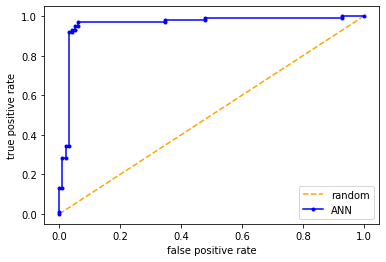

In [46]:
printAUROC(y,y_pred)

In [47]:
cf_matrix = confusion_matrix(y,(y_pred > 0.5))

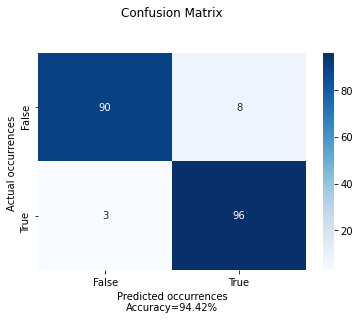

In [48]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('Predicted occurrences\nAccuracy={:0.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
ax.set_ylabel('Actual occurrences ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [49]:
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = y_pred

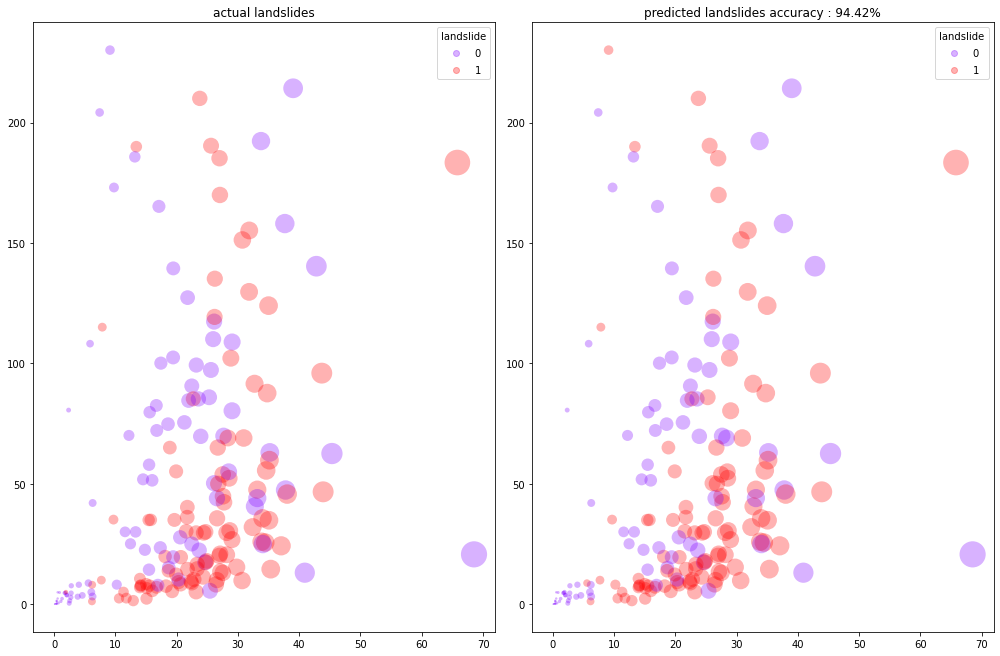

In [50]:
bubble_double_chart(output_proprietario,"slope","slope","elevation")

#### RepeatedStratifiedKfold Assessment 

ref. https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

ref. https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece

In [51]:
print(X.min(axis=0), X.max(axis=0))

[-1.00192557 -1.         -1.00014224 -1.         -1.         -1.16903795
 -6.80518688] [1.08254853 1.03161732 1.1480696  1.85714286 1.         1.
 3.56467966]


In [52]:
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Number of Splits_stratified of X: ',rskf.get_n_splits(X, y),'\n')

# Print_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

Number of Splits_stratified of X:  10 

(157, 7) (157, 1)
(157, 7) (157, 1)
(158, 7) (158, 1)
(158, 7) (158, 1)
(158, 7) (158, 1)
(157, 7) (157, 1)
(157, 7) (157, 1)
(158, 7) (158, 1)
(158, 7) (158, 1)
(158, 7) (158, 1)


In [53]:
print('List of obtained accuracies:', lst_accu_stratified)
print('\nMaximum accuracy:',
      max(lst_accu_stratified), '%')
print('\nMinimum accuracy:',
      min(lst_accu_stratified), '%')
print('\nAvarage accuracy:',
      statistics.mean(lst_accu_stratified), '%')
print('\nStandard deviation:', statistics.stdev(lst_accu_stratified))

List of obtained accuracies: [92.5, 95.0, 89.74358974358975, 100.0, 94.87179487179486, 92.5, 92.5, 94.87179487179486, 97.43589743589743, 94.87179487179486]

Maximum accuracy: 100.0 %

Minimum accuracy: 89.74358974358975 %

Avarage accuracy: 94.42948717948718 %

Standard deviation: 2.8695316300536624


In [54]:
dataset

,slope,aspect,elevation,land_use,lithology,twi,curvature,class
0,33.860043,277.485138,25.912239,90,65,4.319798,-0.015372,1
1,0.727488,159.017288,0.418544,90,2,16.590740,-0.043386,0
2,1.114157,142.506317,1.117189,90,2,16.493561,-0.011949,0
3,20.309313,306.605927,9.144706,30,2,5.782696,-0.010980,1
4,43.904831,316.640686,46.628563,30,2,4.132583,-0.000184,1
...,...,...,...,...,...,...,...,...
192,28.372442,17.409184,68.982224,90,2,4.304924,4.304924,1
193,16.010031,162.229965,51.405090,90,65,5.160524,-2.031868,0
194,23.677940,128.533310,22.392719,90,65,4.225570,-0.711420,0
195,40.913528,28.399397,13.043623,90,2,2.448155,2.316771,0


In [55]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = y_pred
output_proprietario.to_csv('bestANN/mapaSuscetibilidade_proprietaria.csv', encoding="utf-8")

Accuracy: 94.42%


In [56]:
NetworkPerformance(y, y_pred)

Accuracy: 0.944162
Precision: 0.923077
Recall: 0.969697
F1 score: 0.945813
Cohens kappa: 0.888293
ROC AUC: 0.959184
[[90  8]
 [ 3 96]]


In [57]:
output_proprietario

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class,score
0,174,380188.0000,7355077.000,4.319798,-0.015372,33.860043,25.912239,277.485138,65,90,1,9.685786e-01
1,1,369756.0000,7344220.000,16.590740,-0.043386,0.727488,0.418544,159.017288,2,90,0,5.708517e-05
2,62,376611.0000,7353497.000,16.493561,-0.011949,1.114157,1.117189,142.506317,2,90,0,2.394021e-05
3,110,372569.0000,7346250.000,5.782696,-0.010980,20.309313,9.144706,306.605927,2,30,1,9.999746e-01
4,109,370946.0334,7346022.025,4.132583,-0.000184,43.904831,46.628563,316.640686,2,30,1,9.999994e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
192,169,377535.0937,7354527.194,4.304924,4.304924,28.372442,68.982224,17.409184,2,90,1,1.722399e-10
193,87,381307.0000,7356024.000,5.160524,-2.031868,16.010031,51.405090,162.229965,65,90,0,4.053303e-05
194,59,379144.0000,7353357.000,4.225570,-0.711420,23.677940,22.392719,128.533310,65,90,0,5.533416e-03
195,78,380890.0000,7355373.000,2.448155,2.316771,40.913528,13.043623,28.399397,2,90,0,1.296734e-03


ROC AUC=0.959


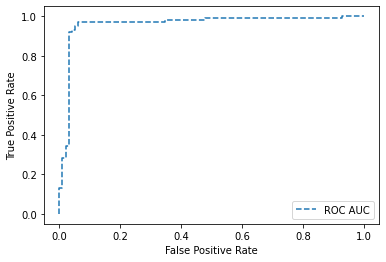

In [58]:
from matplotlib import pyplot
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- ref. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

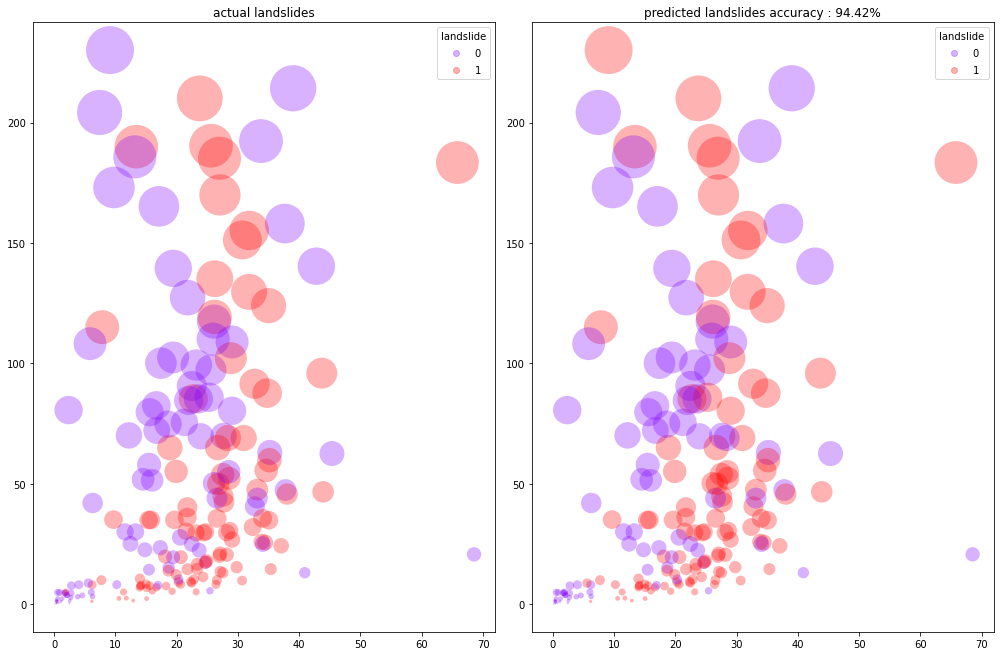

In [59]:
bubble_double_chart(output_proprietario,"elevation","slope","elevation")

In [60]:
end = datetime.datetime.now()
print(end-start)
#quit()

0:54:31.992753


### Keras Framework
__Clasification problem, see best practices:__
- Hyperparameters tuning
- Baseline to custom implementation 

ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/

Agora, configura a rede com os melhores parâmetros

In [61]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

95 train examples
42 validation examples
60 test examples


In [62]:
hypermodel = keras.Sequential()
hypermodel.add(Dense(24, activation='relu', input_dim=input_dim))

hypermodel.add(Dense(24, activation='relu'))
hypermodel.add(Dropout(0.43719886068153724))

hypermodel.add(Dense(1, activation='sigmoid'))
learning_rate= 0.01
myOptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
hypermodel.compile(optimizer=myOptimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [63]:
#model.fit(X_train, y_train, epochs=100, batch_size=5)
history           = hypermodel.fit(X_train, y_train, epochs=500, batch_size=5)
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/500
19/19 [==============================] - 1s 2ms/step - loss: 0.7318 - accuracy: 0.5368
Epoch 2/500
19/19 [==============================] - 0s 1ms/step - loss: 0.7092 - accuracy: 0.4842
Epoch 3/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6720 - accuracy: 0.6105
Epoch 4/500
19/19 [==============================] - 0s 1ms/step - loss: 0.6700 - accuracy: 0.6526
Epoch 5/500
19/19 [==============================] - 0s 1ms/step - loss: 0.6758 - accuracy: 0.5684
Epoch 6/500
19/19 [==============================] - 0s 1ms/step - loss: 0.6706 - accuracy: 0.6316
Epoch 7/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6731 - accuracy: 0.6105
Epoch 8/500
19/19 [==============================] - 0s 1ms/step - loss: 0.6790 - accuracy: 0.5474
Epoch 9/500
19/19 [==============================] - 0s 1ms/step - loss: 0.6505 - accuracy: 0.6316
Epoch 10/500
19/19 [==============================] - 0s 1ms/step - loss: 0.6421 - accuracy: 0.6211
Epoch 11/

Epoch 83/500
19/19 [==============================] - 0s 1ms/step - loss: 0.5116 - accuracy: 0.7263
Epoch 84/500
19/19 [==============================] - 0s 1ms/step - loss: 0.4914 - accuracy: 0.7474
Epoch 85/500
19/19 [==============================] - 0s 2ms/step - loss: 0.4801 - accuracy: 0.7895
Epoch 86/500
19/19 [==============================] - 0s 1ms/step - loss: 0.5082 - accuracy: 0.7158
Epoch 87/500
19/19 [==============================] - 0s 1ms/step - loss: 0.4768 - accuracy: 0.7684
Epoch 88/500
19/19 [==============================] - 0s 1ms/step - loss: 0.5018 - accuracy: 0.7368
Epoch 89/500
19/19 [==============================] - 0s 1ms/step - loss: 0.4672 - accuracy: 0.8105
Epoch 90/500
19/19 [==============================] - 0s 1ms/step - loss: 0.5114 - accuracy: 0.7263
Epoch 91/500
19/19 [==============================] - 0s 1ms/step - loss: 0.4787 - accuracy: 0.7684
Epoch 92/500
19/19 [==============================] - 0s 1ms/step - loss: 0.4909 - accuracy: 0.7474


19/19 [==============================] - 0s 1ms/step - loss: 0.4364 - accuracy: 0.8316
Epoch 165/500
19/19 [==============================] - 0s 1ms/step - loss: 0.4145 - accuracy: 0.8632
Epoch 166/500
19/19 [==============================] - 0s 1ms/step - loss: 0.4209 - accuracy: 0.8105
Epoch 167/500
19/19 [==============================] - 0s 1ms/step - loss: 0.4266 - accuracy: 0.8000
Epoch 168/500
19/19 [==============================] - 0s 1ms/step - loss: 0.4087 - accuracy: 0.7789
Epoch 169/500
19/19 [==============================] - 0s 1ms/step - loss: 0.4438 - accuracy: 0.8000
Epoch 170/500
19/19 [==============================] - 0s 1ms/step - loss: 0.4468 - accuracy: 0.8316
Epoch 171/500
19/19 [==============================] - 0s 1ms/step - loss: 0.4240 - accuracy: 0.7895
Epoch 172/500
19/19 [==============================] - 0s 1ms/step - loss: 0.4160 - accuracy: 0.8211
Epoch 173/500
19/19 [==============================] - 0s 1ms/step - loss: 0.3990 - accuracy: 0.8211
Epoc

19/19 [==============================] - 0s 1ms/step - loss: 0.3836 - accuracy: 0.8421
Epoch 246/500
19/19 [==============================] - 0s 1ms/step - loss: 0.3568 - accuracy: 0.8526
Epoch 247/500
19/19 [==============================] - 0s 1ms/step - loss: 0.3810 - accuracy: 0.8632
Epoch 248/500
19/19 [==============================] - 0s 1ms/step - loss: 0.3499 - accuracy: 0.8737
Epoch 249/500
19/19 [==============================] - 0s 1ms/step - loss: 0.3549 - accuracy: 0.8947
Epoch 250/500
19/19 [==============================] - 0s 1ms/step - loss: 0.3768 - accuracy: 0.8737
Epoch 251/500
19/19 [==============================] - 0s 1ms/step - loss: 0.3476 - accuracy: 0.8316
Epoch 252/500
19/19 [==============================] - 0s 1ms/step - loss: 0.3545 - accuracy: 0.8526
Epoch 253/500
19/19 [==============================] - 0s 1ms/step - loss: 0.3177 - accuracy: 0.8947
Epoch 254/500
19/19 [==============================] - 0s 1ms/step - loss: 0.3623 - accuracy: 0.8526
Epoc

19/19 [==============================] - 0s 1ms/step - loss: 0.3363 - accuracy: 0.8632
Epoch 327/500
19/19 [==============================] - 0s 1ms/step - loss: 0.3637 - accuracy: 0.8211
Epoch 328/500
19/19 [==============================] - 0s 1ms/step - loss: 0.2776 - accuracy: 0.8947
Epoch 329/500
19/19 [==============================] - 0s 1ms/step - loss: 0.2989 - accuracy: 0.9158
Epoch 330/500
19/19 [==============================] - 0s 1ms/step - loss: 0.2919 - accuracy: 0.8632
Epoch 331/500
19/19 [==============================] - 0s 1ms/step - loss: 0.2917 - accuracy: 0.8842
Epoch 332/500
19/19 [==============================] - 0s 1ms/step - loss: 0.3388 - accuracy: 0.8421
Epoch 333/500
19/19 [==============================] - 0s 1ms/step - loss: 0.2941 - accuracy: 0.8842
Epoch 334/500
19/19 [==============================] - 0s 1ms/step - loss: 0.2940 - accuracy: 0.8947
Epoch 335/500
19/19 [==============================] - 0s 1ms/step - loss: 0.2713 - accuracy: 0.9053
Epoc

19/19 [==============================] - 0s 1ms/step - loss: 0.2293 - accuracy: 0.9368
Epoch 408/500
19/19 [==============================] - 0s 1ms/step - loss: 0.1747 - accuracy: 0.9579
Epoch 409/500
19/19 [==============================] - 0s 2ms/step - loss: 0.2399 - accuracy: 0.9053
Epoch 410/500
19/19 [==============================] - 0s 1ms/step - loss: 0.2088 - accuracy: 0.9368
Epoch 411/500
19/19 [==============================] - 0s 1ms/step - loss: 0.2048 - accuracy: 0.9263
Epoch 412/500
19/19 [==============================] - 0s 1ms/step - loss: 0.1892 - accuracy: 0.9789
Epoch 413/500
19/19 [==============================] - 0s 1ms/step - loss: 0.1879 - accuracy: 0.9263
Epoch 414/500
19/19 [==============================] - 0s 1ms/step - loss: 0.2156 - accuracy: 0.9053
Epoch 415/500
19/19 [==============================] - 0s 1ms/step - loss: 0.2247 - accuracy: 0.9053
Epoch 416/500
19/19 [==============================] - 0s 1ms/step - loss: 0.2324 - accuracy: 0.9053
Epoc

19/19 [==============================] - 0s 905us/step - loss: 0.1758 - accuracy: 0.9474
Epoch 489/500
19/19 [==============================] - 0s 1ms/step - loss: 0.1630 - accuracy: 0.9684
Epoch 490/500
19/19 [==============================] - 0s 1ms/step - loss: 0.1753 - accuracy: 0.9263
Epoch 491/500
19/19 [==============================] - 0s 1ms/step - loss: 0.1545 - accuracy: 0.9684
Epoch 492/500
19/19 [==============================] - 0s 1ms/step - loss: 0.1822 - accuracy: 0.9368
Epoch 493/500
19/19 [==============================] - 0s 1ms/step - loss: 0.1644 - accuracy: 0.9474
Epoch 494/500
19/19 [==============================] - 0s 1ms/step - loss: 0.1652 - accuracy: 0.9474
Epoch 495/500
19/19 [==============================] - 0s 1ms/step - loss: 0.2689 - accuracy: 0.8737
Epoch 496/500
19/19 [==============================] - 0s 1ms/step - loss: 0.1572 - accuracy: 0.9474
Epoch 497/500
19/19 [==============================] - 0s 1ms/step - loss: 0.1643 - accuracy: 0.9684
Ep

In [64]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 412


In [65]:
# keras assessment
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 3ms/step - loss: 0.7222 - accuracy: 0.7667
Accuracy: 76.67


In [66]:
# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch)

Epoch 1/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1849 - accuracy: 0.9368
Epoch 2/412
3/3 [==============================] - 0s 2ms/step - loss: 0.2070 - accuracy: 0.9053
Epoch 3/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1732 - accuracy: 0.9579
Epoch 4/412
3/3 [==============================] - 0s 0s/step - loss: 0.1682 - accuracy: 0.9158
Epoch 5/412
3/3 [==============================] - 0s 8ms/step - loss: 0.1876 - accuracy: 0.9579
Epoch 6/412
3/3 [==============================] - 0s 0s/step - loss: 0.1503 - accuracy: 0.9579
Epoch 7/412
3/3 [==============================] - 0s 0s/step - loss: 0.1565 - accuracy: 0.9474
Epoch 8/412
3/3 [==============================] - 0s 8ms/step - loss: 0.1787 - accuracy: 0.9474
Epoch 9/412
3/3 [==============================] - 0s 0s/step - loss: 0.2124 - accuracy: 0.9263
Epoch 10/412
3/3 [==============================] - 0s 0s/step - loss: 0.1392 - accuracy: 0.9474
Epoch 11/412
3/3 [================

3/3 [==============================] - 0s 2ms/step - loss: 0.1460 - accuracy: 0.9579
Epoch 85/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1489 - accuracy: 0.9579
Epoch 86/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.9263
Epoch 87/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1641 - accuracy: 0.9263
Epoch 88/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1333 - accuracy: 0.9789
Epoch 89/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1489 - accuracy: 0.9474
Epoch 90/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1571 - accuracy: 0.9368
Epoch 91/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1812 - accuracy: 0.9579
Epoch 92/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1613 - accuracy: 0.9579
Epoch 93/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1623 - accuracy: 0.9579
Epoch 94/412
3/3 [===============

3/3 [==============================] - 0s 6ms/step - loss: 0.1740 - accuracy: 0.9474
Epoch 168/412
3/3 [==============================] - 0s 6ms/step - loss: 0.1681 - accuracy: 0.9474
Epoch 169/412
3/3 [==============================] - 0s 0s/step - loss: 0.1610 - accuracy: 0.9474
Epoch 170/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1687 - accuracy: 0.9579
Epoch 171/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1779 - accuracy: 0.9684
Epoch 172/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1699 - accuracy: 0.9368
Epoch 173/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1307 - accuracy: 0.9789
Epoch 174/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1842 - accuracy: 0.9368
Epoch 175/412
3/3 [==============================] - 0s 3ms/step - loss: 0.1369 - accuracy: 0.9579
Epoch 176/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1593 - accuracy: 0.9263
Epoch 177/412
3/3 [======

3/3 [==============================] - 0s 2ms/step - loss: 0.1644 - accuracy: 0.9368
Epoch 250/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1626 - accuracy: 0.9474
Epoch 251/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1177 - accuracy: 0.9684
Epoch 252/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1455 - accuracy: 0.9368
Epoch 253/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1409 - accuracy: 0.9579
Epoch 254/412
3/3 [==============================] - 0s 0s/step - loss: 0.1713 - accuracy: 0.9368
Epoch 255/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1337 - accuracy: 0.9684
Epoch 256/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1400 - accuracy: 0.9579
Epoch 257/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1417 - accuracy: 0.9474
Epoch 258/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1703 - accuracy: 0.9474
Epoch 259/412
3/3 [======

3/3 [==============================] - 0s 2ms/step - loss: 0.1513 - accuracy: 0.9579
Epoch 332/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1383 - accuracy: 0.9368
Epoch 333/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1753 - accuracy: 0.9368
Epoch 334/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1328 - accuracy: 0.9684
Epoch 335/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1351 - accuracy: 0.9579
Epoch 336/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1829 - accuracy: 0.9263
Epoch 337/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1539 - accuracy: 0.9684
Epoch 338/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1336 - accuracy: 0.9789
Epoch 339/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1506 - accuracy: 0.9579
Epoch 340/412
3/3 [==============================] - 0s 2ms/step - loss: 0.1617 - accuracy: 0.9579
Epoch 341/412
3/3 [=====

#### Assessment

In [67]:
# Keras assessment
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 2ms/step - loss: 0.7567 - accuracy: 0.7667
Accuracy: 76.67


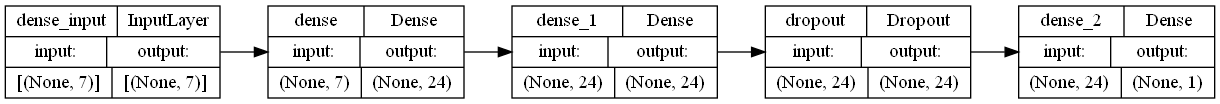

In [68]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved if its accuracy with test sample surpass 85%.

In [69]:
if accuracy >= .85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved!'.format(accuracy))
    hypermodel.save('bestANN\suscetibilidadeKeras_guaruja.pkl')
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

Accuracy: 86.67% testing sample accuracy under .85!


#### RepeatedStratifiedKFold Assessment

In [70]:
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Splits numbers of X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified_keras, X_test_stratified_keras = X[train_index], X[test_index]
    y_train_stratified_keras, y_test_stratified_keras = y[train_index], y[test_index]
    #print(X_train_stratified_keras.shape, y_train_stratified_keras.shape)
    
    yhat_probs = hypermodel.predict(X_test_stratified_keras)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified_keras, yhat_probs > 0.5))

Splits numbers of X:  10 

2/2 [==============================] - 0s 2ms/step


In [71]:
print('List of obtained accuracies:', lst_accu_stratified)
print('\nMaximum accuracy:',
      max(lst_accu_stratified), '%')
print('\nMinimum accuracy:',
      min(lst_accu_stratified), '%')
print('\nAvarage accuracy:',
      statistics.mean(lst_accu_stratified), '%')
print('\nStandard deviation:', statistics.stdev(lst_accu_stratified))

List of obtained accuracies: [85.0, 87.5, 87.17948717948718, 92.3076923076923, 87.17948717948718, 92.5, 82.5, 89.74358974358975, 89.74358974358975, 84.61538461538461]

Maximum accuracy: 92.5 %

Minimum accuracy: 82.5 %

Avarage accuracy: 87.82692307692308 %

Standard deviation: 3.2810731826926425


In [72]:
y_pred = hypermodel.predict(X_test)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

2/2 [==============================] - 0s 2ms/step
Accuracy: 76.67%


In [73]:
y_pred = hypermodel.predict(X_train)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

3/3 [==============================] - 0s 1ms/step
Accuracy: 97.89%


In [74]:
y_pred = hypermodel.predict(X_val)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

2/2 [==============================] - 0s 3ms/step
Accuracy: 80.95%


In [75]:
y_pred = hypermodel.predict(X)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

7/7 [==============================] - 0s 1ms/step
Accuracy: 87.82%


In [76]:
output_keras = None
output_keras = dataset_original
output_keras['score'] = y_pred
output_keras.to_csv('bestANN/mapaSuscetibilidade_keras.csv', encoding="utf-8")
output_keras

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class,score
0,174,380188.0000,7355077.000,4.319798,-0.015372,33.860043,25.912239,277.485138,65,90,1,0.949474
1,1,369756.0000,7344220.000,16.590740,-0.043386,0.727488,0.418544,159.017288,2,90,0,0.000009
2,62,376611.0000,7353497.000,16.493561,-0.011949,1.114157,1.117189,142.506317,2,90,0,0.000009
3,110,372569.0000,7346250.000,5.782696,-0.010980,20.309313,9.144706,306.605927,2,30,1,0.997766
4,109,370946.0334,7346022.025,4.132583,-0.000184,43.904831,46.628563,316.640686,2,30,1,0.995325
...,...,...,...,...,...,...,...,...,...,...,...,...
192,169,377535.0937,7354527.194,4.304924,4.304924,28.372442,68.982224,17.409184,2,90,1,0.000119
193,87,381307.0000,7356024.000,5.160524,-2.031868,16.010031,51.405090,162.229965,65,90,0,0.077789
194,59,379144.0000,7353357.000,4.225570,-0.711420,23.677940,22.392719,128.533310,65,90,0,0.418768
195,78,380890.0000,7355373.000,2.448155,2.316771,40.913528,13.043623,28.399397,2,90,0,0.171862


In [77]:
NetworkPerformance(y, y_pred)

Accuracy: 0.878173
Precision: 0.826087
Recall: 0.959596
F1 score: 0.887850
Cohens kappa: 0.756138
ROC AUC: 0.929499
[[78 20]
 [ 4 95]]


ROC AUC=0.929


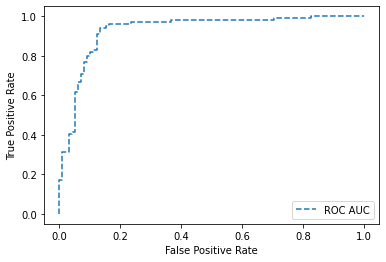

In [78]:
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

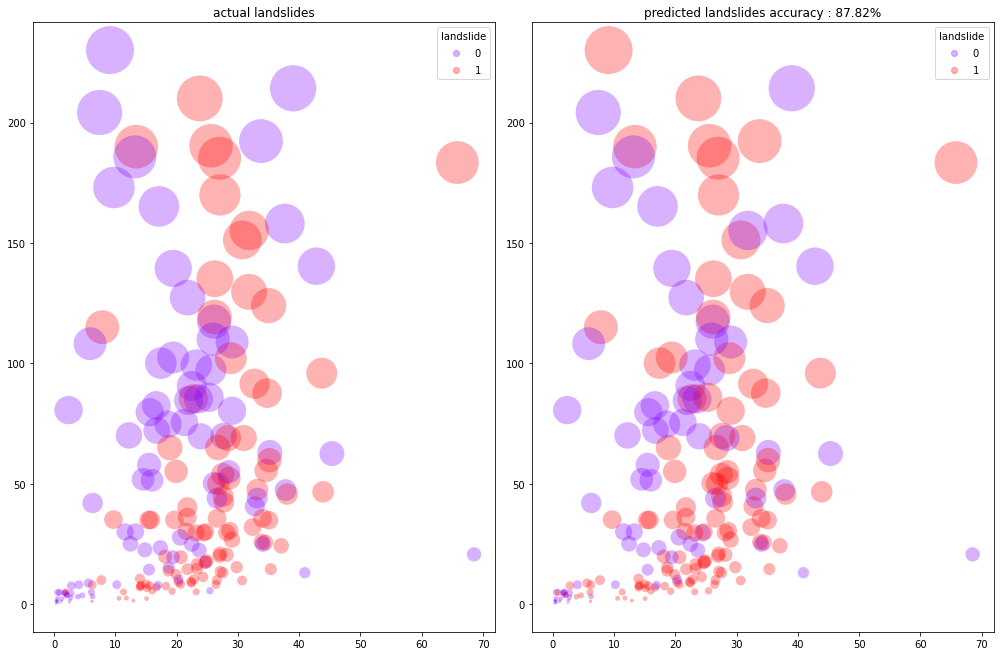

In [79]:
bubble_double_chart(output_proprietario,"elevation","slope","elevation")

In [80]:
end = datetime.datetime.now()
print(end-start)

0:54:55.494836


## References
- ref.1: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref.2: https://www.tensorflow.org/tutorials/structured_data/feature_columns
- ref.3: https://realpython.com/train-test-split-python-data/
- ref.4: https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref.5: https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref.6: https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref.7: https://www.section.io/engineering-education/data-leakage/
- ref.8: https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1
- ref.9: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
- ref. 10: https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb
- ref. 11: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
- ref. 12: http://karpathy.github.io/2019/04/25/recipe/
- ref. 13: https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc